In [29]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [71]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(8):
    if(i == 3 or   i == 7):
        continue
    # if(i == 1 or i == 2 or i == 3 or i == 5 or i == 6 or i == 7):
    #     continue
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_train = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_train = combined_df[y_columns_to_use].values

data_frames_abnormal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/abnormal_mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df = pd.concat(data_frames_abnormal, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_test_abnormal = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_test_abnormal = combined_df[y_columns_to_use].values


data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed_mel_spectrogram/mel_spectrogram_coordinate{i*4+2}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df = pd.concat(data_frames_normal, ignore_index=True)

x_columns_to_use = [f'mel_spectrogram_{i}' for i in range(128)]

x_test_normal = combined_df[x_columns_to_use].values

y_columns_to_use = ['x','y']
y_test_normal = combined_df[y_columns_to_use].values

def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr

std_weight = 3
for idx in range(x_train.shape[1]):
    mean_val = x_train[:,idx].mean()
    std_val = x_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    x_train[:,idx] = min_max_scaler(x_train[:,idx], min_val, max_val)
    x_test_abnormal[:,idx] = min_max_scaler(x_test_abnormal[:,idx], min_val, max_val)
    x_test_normal[:,idx] = min_max_scaler(x_test_normal[:,idx], min_val, max_val)

for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)


In [72]:
WINDOW_LEN = 1

def transform_for_predictor_input(X_arr):
    # 初期化のための値を取得
    start_padding = np.tile(X_arr[0, :].reshape(1, -1), (WINDOW_LEN // 2,1))
    end_padding = np.tile(X_arr[-1,:].reshape(1, -1), (WINDOW_LEN // 2,1))
    
    # 入力配列の前後にパディングを追加
    X_padded = np.concatenate([start_padding, X_arr, end_padding], axis=0)
    
    # トレーニングデータを作成
    X_train = []
    for time_idx in range(X_padded.shape[0] - WINDOW_LEN):
        X_train.append(X_padded[time_idx:time_idx + WINDOW_LEN,:])
    
    return np.array(X_train)

if(WINDOW_LEN > 1):
    x_train = transform_for_predictor_input(x_train)
    x_test_abnormal = transform_for_predictor_input(x_test_abnormal)
    x_test_normal = transform_for_predictor_input(x_test_normal)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
    x_test_abnormal = x_test_abnormal.reshape(x_test_abnormal.shape[0], x_test_abnormal.shape[1]*x_test_abnormal.shape[2])
    x_test_normal = x_test_normal.reshape(x_test_normal.shape[0], x_test_normal.shape[1]*x_test_normal.shape[2])

In [73]:
kl_loss_ratio = 0.
yz_loss_ratio = 0.
stddev = 0

In [74]:


class Encoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, layer_num):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.layer_num = layer_num
        
        self.input_layer = Dense(2**(int(np.log2(input_dim)) + layer_num), activation='relu')
        if layer_num > 1:
            self.denses = [Dense(2**(int(np.log2(input_dim)) + layer), activation='relu') for layer in range(1, layer_num)]
        else:
            self.denses = []
        
        self.dense_mu = Dense(latent_dim, activation='linear')
        self.dense_log_var = Dense(latent_dim, activation='linear')

    def call(self, x):
        x = self.input_layer(x)
        for dense in self.denses:
            x = dense(x)
        z_mu = self.dense_mu(x)
        z_log_var = self.dense_log_var(x)
        return z_mu, z_log_var

class Decoder(tf.keras.Model):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(output_dim, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x,y):
        z_mu, z_log_var = self.encoder(x)
        epsilon = tf.random.normal(shape=(tf.shape(z_mu)[0], self.encoder.latent_dim), mean=0.0, stddev=stddev)
        z = z_mu + tf.exp(0.5 * z_log_var) * epsilon
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss_ratio*tf.reduce_mean(kl_loss))  # 損失を平均化
        # zとyの平均二乗誤差
        mse_loss = tf.reduce_mean(tf.square(z - y))
        self.add_loss(yz_loss_ratio*mse_loss)
        return reconstructed

input_dim = 128*WINDOW_LEN
latent_dim = 2
layer_num = 3

encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim, layer_num=layer_num)
decoder = Decoder(latent_dim=latent_dim, output_dim=input_dim)
vae = VAE(encoder, decoder)

vae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())


# カスタムトレーニングループ
batch_size = 256
epochs = 100
WINDOW_LEN = 10





train_dataset_x = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset_xy = tf.data.Dataset.zip((train_dataset_x, train_dataset_y))

train_dataset_xy = train_dataset_xy.shuffle(buffer_size=1024)
dataset_size = len(x_train)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_dataset = train_dataset_xy.take(train_size)
val_dataset = train_dataset_xy.skip(train_size)

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)



for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train, y_batch_train)
            loss = vae.compiled_loss(x_batch_train, reconstructed, regularization_losses=vae.losses)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        if step % 100 == 0:
            print(f'Training loss at step {step}: {loss.numpy()}')

    for x_batch_val, y_batch_val in val_dataset:
        val_reconstructed = vae(x_batch_val, y_batch_val)
        val_loss = vae.compiled_loss(x_batch_val, val_reconstructed, regularization_losses=vae.losses)
    print(f'Validation loss: {val_loss.numpy()}')

Epoch 1/100


c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:618: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


Training loss at step 0: 0.014342492446303368
Validation loss: 0.01549516525119543
Epoch 2/100
Training loss at step 0: 0.012372591532766819
Validation loss: 0.01309055183082819
Epoch 3/100
Training loss at step 0: 0.011380188167095184
Validation loss: 0.011304602026939392
Epoch 4/100
Training loss at step 0: 0.01106741651892662
Validation loss: 0.012287130579352379
Epoch 5/100
Training loss at step 0: 0.010068215429782867
Validation loss: 0.012776168063282967
Epoch 6/100
Training loss at step 0: 0.01051686517894268
Validation loss: 0.01400663424283266
Epoch 7/100
Training loss at step 0: 0.010400667786598206
Validation loss: 0.012482581660151482
Epoch 8/100
Training loss at step 0: 0.010244986042380333
Validation loss: 0.01246325857937336
Epoch 9/100
Training loss at step 0: 0.010663235560059547
Validation loss: 0.012737680226564407
Epoch 10/100
Training loss at step 0: 0.010319503024220467
Validation loss: 0.011493249796330929
Epoch 11/100
Training loss at step 0: 0.00979098863899707

In [75]:
x_train.shape

(14735, 128)

In [76]:
train_reconstructed = vae.call(x_train, y_train)

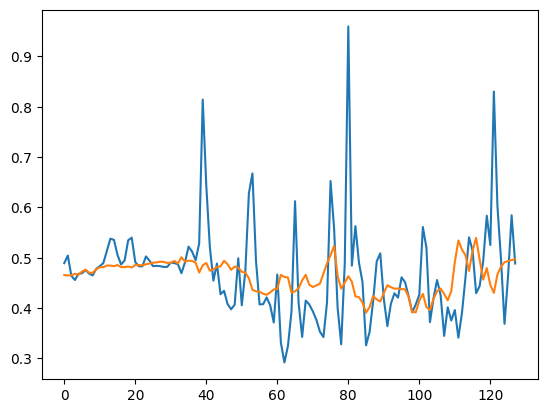

In [77]:
index = 2000
plt.plot(x_train[index])
plt.plot(train_reconstructed[index])

In [78]:
train_encoded = vae.encoder(x_train)


In [639]:
train_encoded = train_encoded[0].numpy()

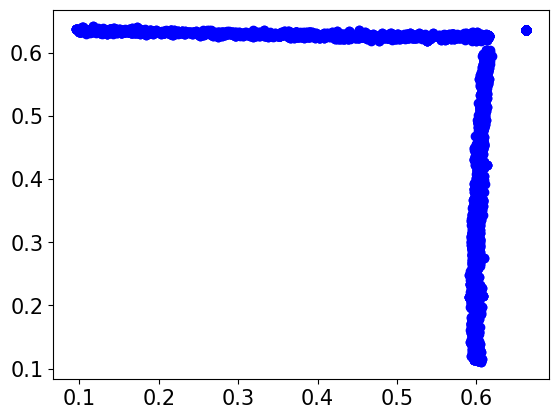

In [640]:
plt.scatter(y_train[:,0], y_train[:,1], c='blue', label='normal') 

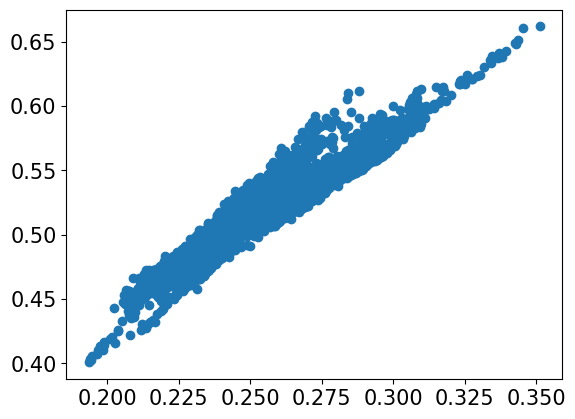

In [641]:
plt.scatter(train_encoded[:, 0], train_encoded[:, 1])

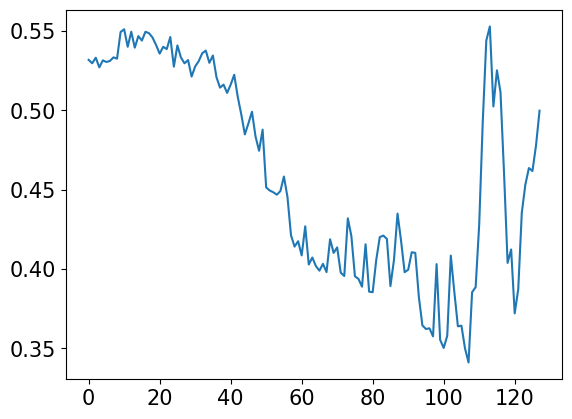

In [642]:
#正常データの再構成をプロットしたい　折れ線グラフで
plt.plot(reconstructed_train, label='reconstructed')

In [643]:
encoded_normal = vae.encoder(x_test_normal)


In [644]:
encoded_normal = encoded_normal[0].numpy()

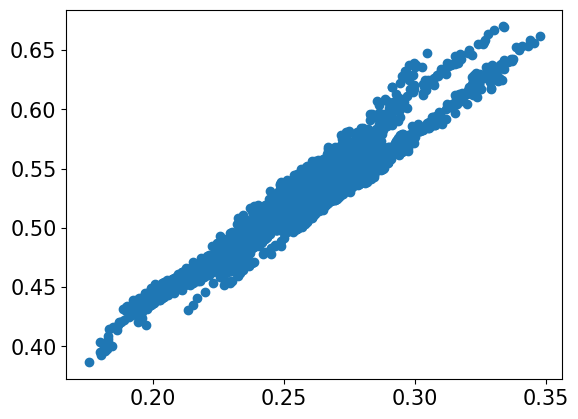

In [645]:
plt.plot(encoded_normal[:,0],encoded_normal[:,1],'o',label='normal')

AUC: 0.9920


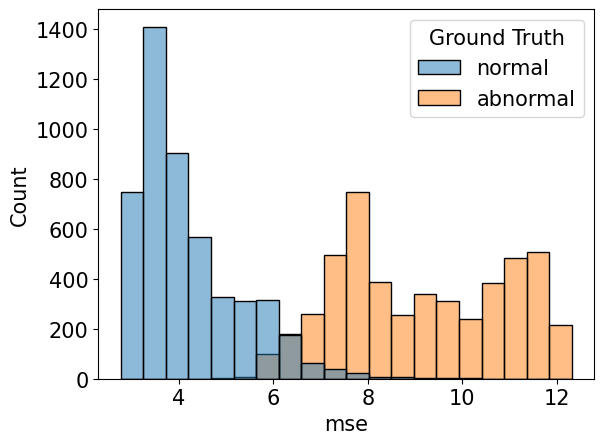

In [646]:
import seaborn as sns
mse_abnormal =  np.sqrt(np.sum((vae.call(x_test_abnormal, y_test_abnormal) - x_test_abnormal)**2, axis=1))
mse_normal = np.sqrt(np.sum((vae.call(x_test_normal,y_test_normal) - x_test_normal)**2, axis=1))

plt_df_normal = pd.DataFrame({'mse':mse_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mse_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'



# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")

In [16]:
import matplotlib.pyplot  as plt

In [57]:
abnormal_encoded = vae.encoder(x_test_abnormal)
abnormal_encoded = np.array(abnormal_encoded)
abnormal_encoded.shape

(2, 4913, 2)

In [58]:
normal_encoded = vae.encoder(x_test_normal)
normal_encoded = np.array(normal_encoded)
normal_encoded.shape

(2, 4911, 2)

In [59]:
abnormal_encoded = abnormal_encoded[:,:,1]
normal_encoded = normal_encoded[:,:,1]

In [61]:
normal_encoded.shape

(2, 4911)

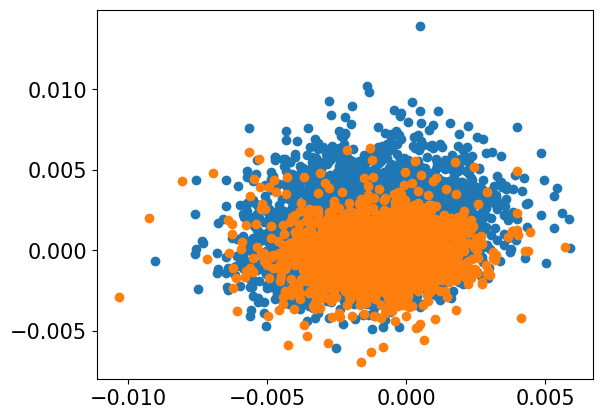

In [63]:
plt.scatter(abnormal_encoded[0], abnormal_encoded[1], label='abnormal')
plt.scatter(normal_encoded[0], normal_encoded[1], label='normal')

NameError: name 'model' is not defined

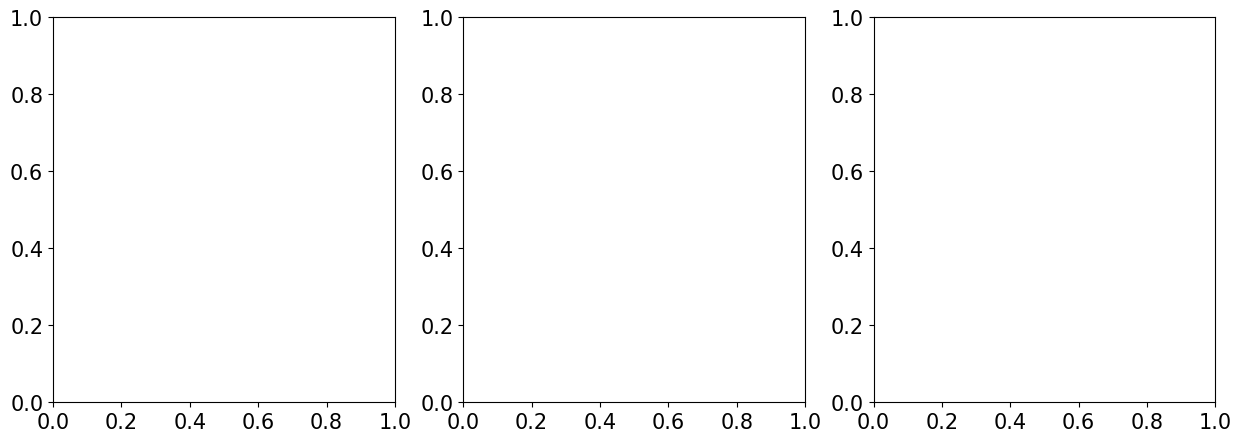

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.rcParams.update({'font.size': 15})
for idx, sound_weight in enumerate([0, 0.5, 1]):
    encoded = model.encode(sound_weight=sound_weight, x=np.concatenate((X['Sound'], X['Force']), axis=1))
    sns.scatterplot(x=encoded[:,0], y=encoded[:,1], hue=y, ax=axes[idx], palette='tab10')
    axes[idx].set_title(f'sound_weight={sound_weight}')
# sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [56]:
encoding_dim = 2
layer_num = 3
sound_dim = X['Sound'].shape[1]
vae = VAE(sound_dim, layer_num, encoding_dim)
vae.compile(optimizer='adam', loss=lambda x, y: tf.keras.losses.binary_crossentropy(x, y)*sound_dim)

NameError: name 'X' is not defined

In [ ]:
vae.fit(x=X['Sound'],
        y=X['Sound'],
        epochs=2, 
        batch_size=64,
        shuffle=True, 
        validation_split=0.2
        )

Epoch 1/2


ResourceExhaustedError: in user code:

    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ResourceExhaustedError: Exception encountered when calling layer "vae_4" (type VAE).
    
    in user code:
    
        File "C:\Users\kokie\AppData\Local\Temp\ipykernel_15604\2587561281.py", line 48, in call  *
            z_mu, z_log_var = self.encoder(x)
        File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ResourceExhaustedError: Exception encountered when calling layer "encoder_4" (type Encoder).
        
        in user code:
        
            File "C:\Users\kokie\AppData\Local\Temp\ipykernel_15604\2587561281.py", line 16, in call  *
                x = self.denses[-layer](x)
            File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 1920, in random_uniform
                return tf.random.uniform(
        
            ResourceExhaustedError: failed to allocate memory [Op:AddV2]
        
        
        Call arguments received by layer "encoder_4" (type Encoder):
          • x=tf.Tensor(shape=(None, 3999), dtype=float32)
    
    
    Call arguments received by layer "vae_4" (type VAE):
      • x=tf.Tensor(shape=(None, 3999), dtype=float32)


In [ ]:
vae.build(input_shape=(None, sound_dim))
vae.summary()

ResourceExhaustedError: Exception encountered when calling layer "encoder_2" (type Encoder).

in user code:

    File "C:\Users\kokie\AppData\Local\Temp\ipykernel_15604\2084384801.py", line 15, in call  *
        x = self.denses[-layer](x)
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kokie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 1920, in random_uniform
        return tf.random.uniform(

    ResourceExhaustedError: OOM when allocating tensor with shape[16384,8192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]


Call arguments received by layer "encoder_2" (type Encoder):
  • x=tf.Tensor(shape=(None, 3999), dtype=float32)